In [87]:
import os
from pathlib import Path

import numpy as np
from edpyt.espace import build_espace, screen_espace
from edpyt.gf2_lanczos import build_gf2_lanczos
from edpyt.shared import params
from matplotlib import pyplot as plt
from scipy.signal import find_peaks

new_path = '/capstor/scratch/cscs/ajayaraj/qtpyt-tests/AuBDA13CH2/run1'
os.chdir(new_path)


In [88]:
class Sigma:

    def __init__(self, gf, H_eff, eta=1e-5):
        self.gf = gf
        self.eta = eta
        self.H_eff = H_eff

    def retarded(self, energy):
        energies = np.atleast_1d(energy)
        g = self.gf(energies, self.eta)
        sigma = np.empty((energies.size,self.gf.n,self.gf.n), complex)
        for e, energy in enumerate(energies):
            sigma[e] = energy - self.H_eff - np.linalg.inv(g[...,e])
        return sigma


In [89]:
path = Path('/capstor/scratch/cscs/ajayaraj/qtpyt-tests/AuBDA13CH2/run1/output/lowdin')
H_eff = np.load(path/'effective_hamiltonian.npy')
nimp = H_eff.shape[0]
occupancy_goal = np.load(path/'occupancies_38.68.npy')

In [ ]:
de = 1e-3
energies = np.arange(-1.0, 1.0, de)
eta = 5e-2
# beta = 38.68
beta = 70
params['z'] = occupancy_goal

In [ ]:
V = np.loadtxt(path/'U_matrix.txt')
DC = np.diag(V.diagonal()*(occupancy_goal-0.5))
neig = np.ones((nimp+1)*(nimp+1),int) * 4

In [ ]:
espace, egs = build_espace(H_eff-DC, V, neig_sector=neig)
screen_espace(espace, egs, beta)
gf = build_gf2_lanczos(H_eff-DC, V, espace, beta, egs)
# DOS = -1/np.pi * gf(energies, eta).imag.trace(axis1=0,axis2=1)

# espace, egs = build_espace(H_eff, np.zeros_like(H_eff), neig_sector=neig)
# screen_espace(espace, egs, beta)
# gf0 = build_gf2_lanczos(H_eff, np.zeros_like(H_eff), espace, beta, egs)
# DOS0 = -1/np.pi * gf0(energies, eta).imag.trace(axis1=0,axis2=1)

# # plt.plot(energies, DOS0, label="U=0")
# plt.plot(energies, DOS, label="U matrix")
# plt.legend()
# plt.yscale('log')
# plt.show()

In [94]:
sigma = Sigma(gf, H_eff, eta=eta)
sig = sigma.retarded(energies)
output_path = Path('/capstor/scratch/cscs/ajayaraj/qtpyt-tests/AuBDA13CH2/check_reference/output/lowdin/beta_38.68')
np.save(output_path/'ed_sigma_fix_U.npy', sig)
sig = np.load(output_path/'ed_sigma_fix_U.npy')
sig_trace = np.trace(sig,axis1=1,axis2=2)

In [95]:
ref = np.loadtxt("/capstor/scratch/cscs/ajayaraj/qtpyt-tests/AuBDA13CH2/reference/sigma_ed_uii_trace.txt")
ref_energy = ref[:,0]
ref_real = ref[:,1]
ref_imag = ref[:,2]


In [96]:
ref2 = np.loadtxt("/capstor/scratch/cscs/ajayaraj/qtpyt-tests/AuBDA13CH2/reference/sigma_ed_trace.txt")
ref2_energy = ref2[:,0]
ref2_real = ref2[:,1]
ref2_imag = ref2[:,2]

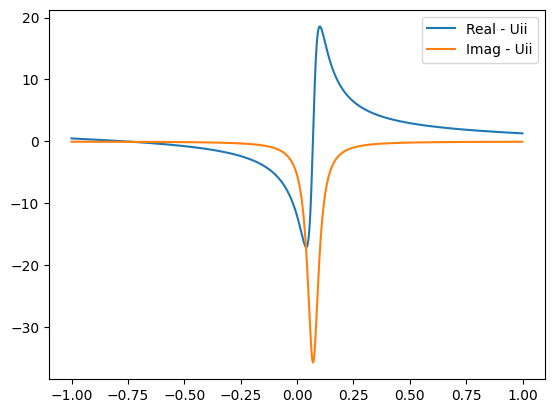

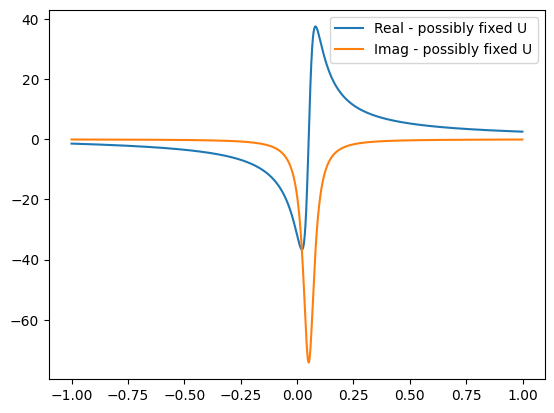

In [97]:
plt.plot(ref_energy, ref_real, label="Real - Uii")
plt.plot(ref_energy, ref_imag, label="Imag - Uii")
plt.legend()
plt.show()
plt.plot(ref2_energy, ref2_real, label="Real - possibly fixed U")
plt.plot(ref2_energy, ref2_imag, label="Imag - possibly fixed U")
plt.legend()
plt.show()


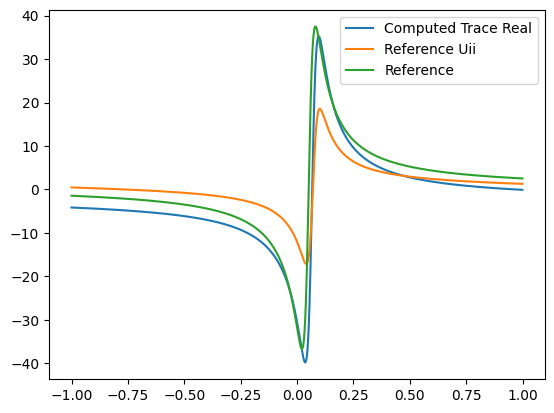

Real part peak positions (computed): [0.096]
Real part dip positions (computed): [0.036]


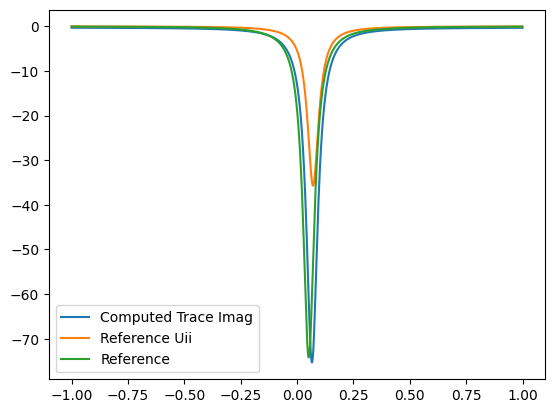

Imaginary part peak positions (computed): []
Imaginary part dip positions (computed): [0.066]


In [98]:
# Plot the real part of the trace
plt.plot(energies, sig_trace.real, label="Computed Trace Real")
plt.plot(ref_energy, ref_real, label="Reference Uii")
plt.plot(ref2_energy, ref2_real, label="Reference")
# plt.ylim(-10, 10)
# plt.xlim(-1,0.5)
plt.legend()
plt.show()

# Find and print peaks and dips for the real part of the computed trace
real_peaks, _ = find_peaks(sig_trace.real)
real_dips, _ = find_peaks(-sig_trace.real)
real_peak_positions = energies[real_peaks]
real_dip_positions = energies[real_dips]
print("Real part peak positions (computed):", real_peak_positions)
print("Real part dip positions (computed):", real_dip_positions)

# Plot the imaginary part of the trace
plt.plot(energies, sig_trace.imag, label="Computed Trace Imag")
plt.plot(ref_energy, ref_imag, label="Reference Uii")
plt.plot(ref2_energy, ref2_imag, label="Reference")
# plt.ylim(-10, 10)
plt.legend()
plt.show()

# Find and print peaks and dips for the imaginary part of the computed trace
imag_peaks, _ = find_peaks(sig_trace.imag)
imag_dips, _ = find_peaks(-sig_trace.imag)
imag_peak_positions = energies[imag_peaks]
imag_dip_positions = energies[imag_dips]
print("Imaginary part peak positions (computed):", imag_peak_positions)
print("Imaginary part dip positions (computed):", imag_dip_positions)


In [69]:
from qtpyt.base.selfenergy import DataSelfEnergy as BaseDataSelfEnergy
from qtpyt.projector import expand


class DataSelfEnergy(BaseDataSelfEnergy):
    """Wrapper"""

    def retarded(self, energy):
        return expand(S_molecule_identity, super().retarded(energy), idx_molecule)


def load(filename):
    ed = np.load(filename)
    print(ed.shape)
    return DataSelfEnergy(energies, np.load(filename))

In [70]:
data_folder = "output/lowdin"
index_active_region = np.load(f"{data_folder}/index_active_region.npy")
nodes = [0, 810, 1116, 1278, 1584, 2394]
imb = 2
S_molecule_identity = np.eye(9)
idx_molecule = (
    index_active_region - nodes[imb]
)  # indices of active region w.r.t molecule


(2000, 9, 9)


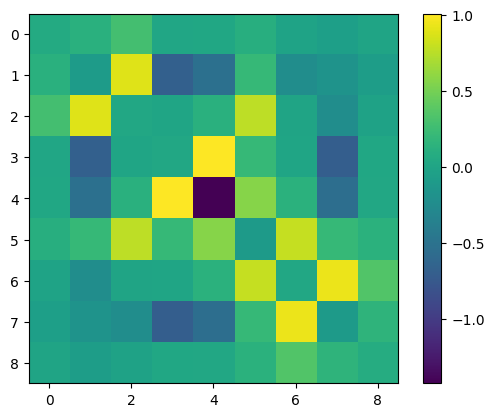

In [106]:
ed_data_folder = "../reference"
ed_sigma_file = f"{ed_data_folder}/sigma_ed.npy"
ed_sigma = load(ed_sigma_file)
ed = np.load(ed_sigma_file)
plt.imshow(ed.real[10])
plt.colorbar()
plt.show()

(2000, 9, 9)


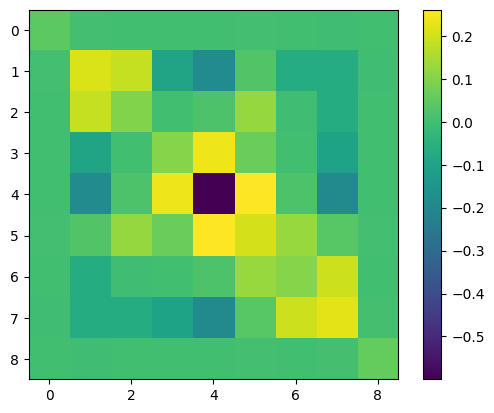

In [107]:
ed_sigma_file = f"{ed_data_folder}/sigma_ed_uii.npy"
ed_sigma = load(ed_sigma_file)
ed = np.load(ed_sigma_file)
plt.imshow(ed.real[10])
plt.colorbar()
plt.show()